# Data 620 Project 1: NFL Data

The 2016 NFL season was a memorable one. There were upsets, games in London, Christmas games and in the end, there was one of the biggest comebacks in Super Bowl history. Kaggle(https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data#spreadspoke_scores.csv)  has documented every game of the NFL season since 1966, showing the home and away teams with their respective scores. For our purposes we will export just the 2016 season to a CSV and to Github. Our goal is to see how the season matchups lead to playoff eligibility and wins.


In [1]:
%matplotlib inline
import networkx as nx
import pandas as pd
from scipy import stats
import matplotlib
import numpy as np
matplotlib.style.use('ggplot')

# Data
Each team played 16 regular season games and 12 teams made the playoffs. With a total of 32 NFL teams not every team played each other, so we should be able to see how different matchups lead to a team making or missing the playoffs. Unforunately our data only showed 9 games played for each team but had the correct playoff teams and Super Bowl matchups.

In [21]:
season16 = pd.read_csv('https://raw.githubusercontent.com/dquarshie89/Data-620/master/Assignment%203/2016nfl.csv'
                         , header = 0)
season16.head()


,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_detail,weather_temperature,weather_wind_mph,weather_humidity,score_home,score_away,stadium_neutral,schedule_playoff
0,9/8/16,2016,1,Denver Broncos,Carolina Panthers,Sports Authority Field at Mile High,CAR,-3.0,40.5,NaN,82,2,NaN,21,20,False,False
1,9/11/16,2016,1,Arizona Cardinals,New England Patriots,University of Phoenix Stadium,ARI,-8.5,44.0,DOME,72,0,NaN,21,23,False,False
2,9/11/16,2016,1,Atlanta Falcons,Tampa Bay Buccaneers,Georgia Dome,ATL,-2.5,47.0,DOME,72,0,NaN,24,31,False,False
3,9/11/16,2016,1,Baltimore Ravens,Buffalo Bills,M&T Bank Stadium,BAL,-3.0,44.5,NaN,82,7,NaN,13,7,False,False
4,9/11/16,2016,1,Dallas Cowboys,New York Giants,Cowboys Stadium,NYG,-1.0,47.5,DOME,72,0,NaN,19,20,False,False


In [22]:
#Make a dataframe for jus the regular season games
reg_season = season16[season16.schedule_week <= '17']
reg_season.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_detail,weather_temperature,weather_wind_mph,weather_humidity,score_home,score_away,stadium_neutral,schedule_playoff
0,9/8/16,2016,1,Denver Broncos,Carolina Panthers,Sports Authority Field at Mile High,CAR,-3.0,40.5,NaN,82,2,NaN,21,20,False,False
1,9/11/16,2016,1,Arizona Cardinals,New England Patriots,University of Phoenix Stadium,ARI,-8.5,44.0,DOME,72,0,NaN,21,23,False,False
2,9/11/16,2016,1,Atlanta Falcons,Tampa Bay Buccaneers,Georgia Dome,ATL,-2.5,47.0,DOME,72,0,NaN,24,31,False,False
3,9/11/16,2016,1,Baltimore Ravens,Buffalo Bills,M&T Bank Stadium,BAL,-3.0,44.5,NaN,82,7,NaN,13,7,False,False
4,9/11/16,2016,1,Dallas Cowboys,New York Giants,Cowboys Stadium,NYG,-1.0,47.5,DOME,72,0,NaN,19,20,False,False


# Team Records
Now that we have the regular season games we'll make a dataframe for the overall records for each team. We'll also have the win-loss perccentage, if they made the playoffs, degree, eigenvector, and closeness centrality columns.

In [23]:
home = set(reg_season.team_home.unique())
away = set(reg_season.team_away.unique())
teams = list(home.union(away))

teams.sort()
record = pd.DataFrame({'Team':teams})
record['Win'] = 0
record['Loss'] = 0
record['WLP'] = 0
record['degcen'] = 0
record['eigencen'] = 0
record['closecen'] = 0
record['betweencen'] = 0
record['Playoffs'] = 'No'
record.head()

,Team,Win,Loss,WLP,degcen,eigencen,closecen,betweencen,Playoffs
0,Arizona Cardinals,0,0,0,0,0,0,0,No
1,Atlanta Falcons,0,0,0,0,0,0,0,No
2,Baltimore Ravens,0,0,0,0,0,0,0,No
3,Buffalo Bills,0,0,0,0,0,0,0,No
4,Carolina Panthers,0,0,0,0,0,0,0,No


In [24]:
# See how many games each team won/ lossed
for index, row in reg_season.iterrows():
    if row['score_home'] > row['score_away']:
        record.loc[record['Team'] == row['team_home'], 'Win'] = record.loc[record['Team'] == row['team_home'], 'Win'] + 1
        record.loc[record['Team'] == row['team_away'], 'Loss'] = record.loc[record['Team'] == row['team_away'], 'Loss'] + 1
    if row['score_home'] < row['score_away']:
        record.loc[record['Team'] == row['team_home'], 'Loss'] = record.loc[record['Team'] == row['team_home'], 'Loss'] + 1
        record.loc[record['Team'] == row['team_away'], 'Win'] = record.loc[record['Team'] == row['team_away'], 'Win'] + 1

# Mark each team that made the playoffs
for index, row in record.iterrows():
    if row['Team'] == 'Atlanta Falcons'or row['Team'] == 'Oakland Raiders' or row['Team'] == 'Dallas Cowboys' or row['Team'] == 'Green Bay Packers'or row['Team'] == 'Houston Texans' or row['Team'] == 'Kansas City Chiefs' or row['Team'] == 'Kansas City Chiefs' or row['Team'] ==  'New England Patriots' or row['Team'] =='Pittsburgh Steelers'or row['Team'] =='Seattle Seahawks' or row['Team'] == 'Detroit Lions'or row['Team'] =='New York Giants':
        record.loc[record['Team'] == row['Team'], 'Playoffs'] = 'Yes'

record['WLP'] = record['Win']/(record['Win']+record['Loss'])

record.head()

,Team,Win,Loss,WLP,degcen,eigencen,closecen,betweencen,Playoffs
0,Arizona Cardinals,4,5,0.444444,0,0,0,0,No
1,Atlanta Falcons,5,3,0.625000,0,0,0,0,Yes
2,Baltimore Ravens,5,4,0.555556,0,0,0,0,No
3,Buffalo Bills,3,5,0.375000,0,0,0,0,No
4,Carolina Panthers,3,6,0.333333,0,0,0,0,No


# Building the Graph

In [11]:
# Make a network x from the edge list stored in pandas.
G = nx.from_pandas_edgelist(reg_season, 'team_home', 'team_away')


#Number of teams
nx.number_of_nodes(G)

32

In [12]:
#Number of games played.
nx.number_of_edges(G)

130

In [13]:
#Get the degree, Eigenvector, Closeness and Betweeness
deg = nx.degree(G) 
eig = nx.eigenvector_centrality(G)
clo = nx.closeness_centrality(G)
btw = nx.betweenness_centrality(G)

In [14]:
#Input them into our record dataframe
for index, row in record.iterrows():
    record.loc[record['Team'] == row['Team'], 'degcen'] = deg[row['Team']]
    record.loc[record['Team'] == row['Team'], 'eigencen'] = eig[row['Team']]
    record.loc[record['Team'] == row['Team'], 'closecen'] = clo[row['Team']]
    record.loc[record['Team'] == row['Team'], 'betweencen'] = btw[row['Team']]

# Degree Centrality
Using our centrality measure we will run T-tests to see if there the differences between playoff teams and ones that did not make it. 

$H_0 :$ There is no difference in the average degree centrality for playoff teams vs teams that are non playoff teams.

$H_A :$ There is a difference in the degree centrality.

Ttest_indResult(statistic=-0.20821287461650193, pvalue=0.8364699052199929)

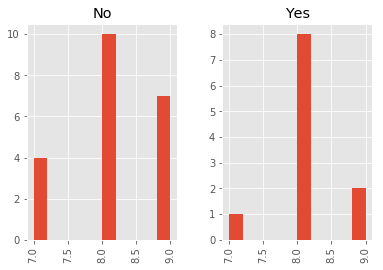

In [15]:
record['degcen'].hist(by = record['Playoffs'])
stats.ttest_ind(record.loc[record['Playoffs'] == 'Yes', 'degcen'],
                record.loc[record['Playoffs'] == 'No', 'degcen'])

From our T-test we find a test statistic of -0.28 and an p-value of 0.836. Therefore we fail to reject the null hypothesis and conclude that there is no difference in degree centrality between the two groups.

# Eigenvector Centrality

Ttest_indResult(statistic=0.0905707815778604, pvalue=0.9284356760771567)

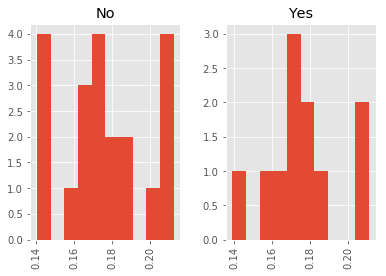

In [16]:
record['eigencen'].hist(by = record['Playoffs'])
stats.ttest_ind(record.loc[record['Playoffs'] == 'Yes', 'eigencen'],
                record.loc[record['Playoffs'] == 'No', 'eigencen']) 

From our T-test we find a test statistic of 0.09 and an p-value of 0.928. Therefore we fail to reject the null hypothesis and conclude that there is no difference in eigenvector centrality between the two groups.

# Closeness Centrality

Ttest_indResult(statistic=-0.42655211481956856, pvalue=0.6727509908257909)

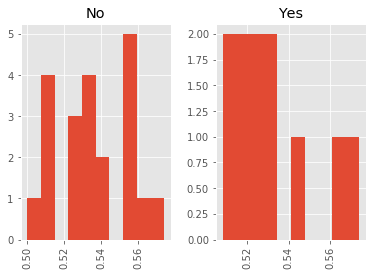

In [17]:
record['closecen'].hist(by = record['Playoffs'])
stats.ttest_ind(record.loc[record['Playoffs'] == 'Yes', 'closecen'],
                record.loc[record['Playoffs'] == 'No', 'closecen']) 

From our T-test we find a test statistic of 0.42 and an p-value of 0.673. Therefore we fail to reject the null hypothesis and conclude that there is no difference in closeness centrality between the two groups.

# Betweenness Centrality

Ttest_indResult(statistic=-0.716351963883483, pvalue=0.4793138271830645)

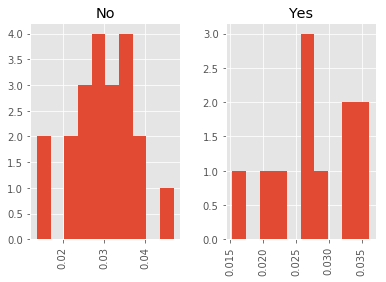

In [18]:
record['betweencen'].hist(by = record['Playoffs'])
stats.ttest_ind(record.loc[record['Playoffs'] == 'Yes', 'betweencen'],
                record.loc[record['Playoffs'] == 'No', 'betweencen'])

From our T-test we find a test statistic of 0.71 and an p-value of 0.479. Therefore we fail to reject the null hypothesis and conclude that there is no difference in betweenness centrality between the two groups.

# Drawing the graph

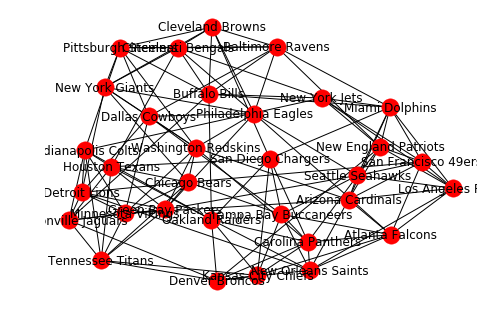

In [20]:
nx.draw(G, with_labels=True)

# Conclusion
While we weren't able to able to see much of difference in the play off teams versus the ones that did not make it we can still make some conclusions from what we saw. We know that NFL teams don't get to chose their schedule and we did not have any data on the strength of the teams. Knowing that, we can assume that there would not be many differences in the teams. We also did not have all the regular season data, only getting 9 games. More games would have given us more data and more to work with.